In [15]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector, Gate
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import array_to_latex, plot_histogram
from qutip import hilbert_dist, Qobj, fock_dm

import random

import pyswarms as ps
import pyswarms.backend as P
from pyswarms.backend.topology import Star

import numpy as np
import matplotlib.pyplot as plt

## Introduction

To optimize a generic 3 qubit unitary, we can build it using a set of generic rotation gates composed of 11 single qubit unitaries and 4 two qubit unitaries. This process is outlined in the paper 'Optimal Implementation of Quantum Gates with Two Controls:
A Detailed Proof' by Jens Palsberg and Nengkun Yu. In this assignement we used the methods in this paper to find an approximiate solution to the Toffoli gate (CCNOT) using only 4 two qubit gates. I was able to measure how close my generated Toffoli gate was to the original by comparing it to the Hilbert Schmidt distance which is outlined later.

## The Toffoli Gate and the Hilbert Schmidt Distance
Here's the native Toffoli gate from qiskit:

In [20]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
ccx_gate = Operator(qc).data
array_to_latex(ccx_gate)

<IPython.core.display.Latex object>

Next steps is to to have a function to measure the 'closeness' to an approximate matrix. This can be done simply with the Hilbert Schmidt Distance. This is given by the following fromula from Jens' paper 'Approximate Quantum Computing': 

In [21]:
def get_hilbert_shmidt_distance(gate1, gate2):
    return hilbert_dist(Qobj(gate1), Qobj(gate2))

def my_hilbert_schmidt_distance(gate1, gate2):
    return np.sqrt(1 - (np.abs(np.trace(np.conj(gate1).T @ gate2))**2) / (2**3)**2)

In [22]:
print("Hilbert Schmidt Distance of CCX with itself: ", get_hilbert_shmidt_distance(ccx_gate, ccx_gate))
print("My Hilbert Schmidt Distance of CCX with itself: ", my_hilbert_schmidt_distance(ccx_gate, ccx_gate))

Hilbert Schmidt Distance of CCX with itself:  0.0
My Hilbert Schmidt Distance of CCX with itself:  0.0


In [ ]:
class SingleQubitU(Gate):
    def __init__(self, theta, phi, lam):
        super().__init__('U1', 1, [theta, phi, lam])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        theta = float(self.params[0])
        phi = float(self.params[1])
        lam = float(self.params[2])
        return UGate(theta, phi, lam).to_matrix()

In [ ]:
class TwoQubitU(Gate):
    def __init__(self, alpha1, alpha2, alpha3):
        super().__init__('U2', 2, [alpha1, alpha2, alpha3])
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0, 1])
        self.definition = qc
    def to_matrix(self):
        alpha1 = float(self.params[0])
        alpha2 = float(self.params[1])
        alpha3 = float(self.params[2])

        rxx_gate = RXXGate(alpha1).to_matrix()
        ryy_gate = RYYGate(alpha2).to_matrix()
        rzz_gate = RZZGate(alpha3).to_matrix()

        return rxx_gate @ ryy_gate @ rzz_gate

In [75]:
class ParamVectorItterator:
    def __init__(self, param_vector):
        self.param_vector = param_vector
        self.index = 0
    def __iter__(self):
        return self
    def __next__(self):
        if self.index < len(self.param_vector):
            start = self.index
            end = self.index + 3
            params = self.param_vector[start:end]
            self.index += 3
            return params
        else:
            raise StopIteration

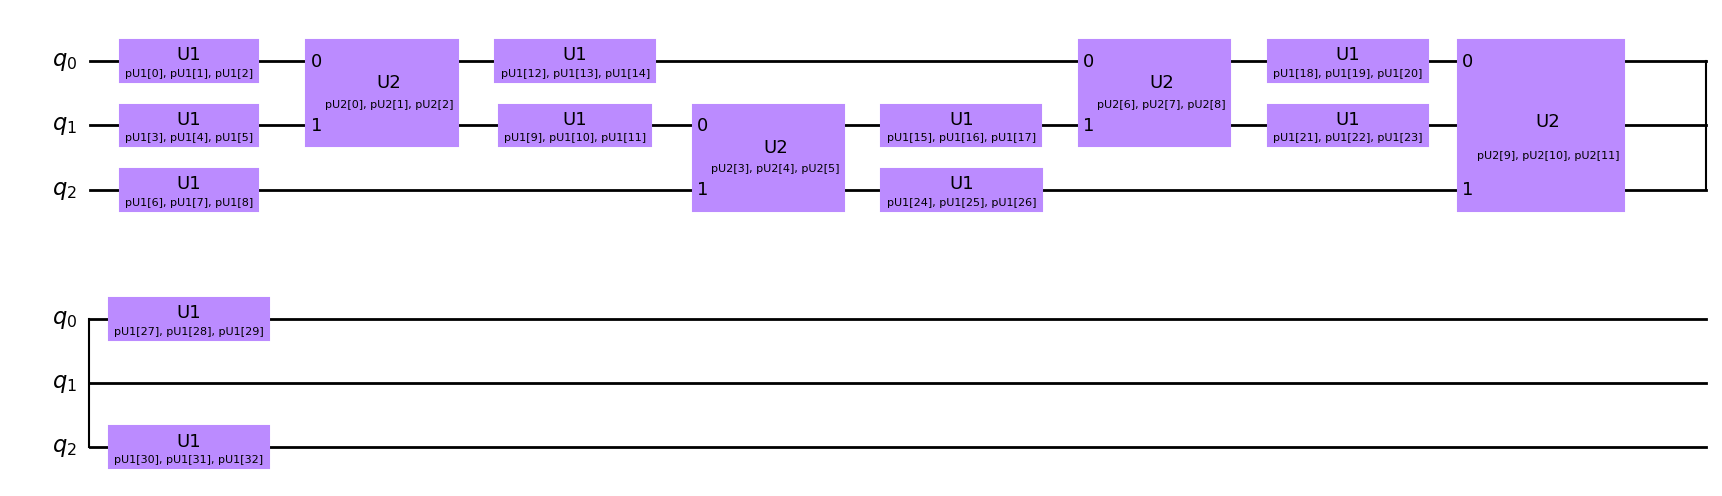

In [76]:
approx_CCNOT_qc = QuantumCircuit(3, name="Approx CCNOT")

# Define parameters
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')

num_U1_params = 3 * 11
num_U2_params = 3 * 4

pU1 = ParameterVector('pU1', num_U1_params)
pU1_itter = ParamVectorItterator(pU1)
pU2 = ParameterVector('pU2', num_U2_params)
pU2_itter = ParamVectorItterator(pU2)

# Create the circuit
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [1, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.draw(output='mpl')

In [69]:
def opt_func(vals):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        distances.append(my_hilbert_schmidt_distance(ccx_gate, approx_CCNOT_matrix))

    return distances

Running pyswarms optimization

In [80]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
init_pos = np.array([best_pos_thus_far for _ in range(250)])
optimizer = ps.single.GlobalBestPSO(n_particles=200, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
cost, pos = optimizer.optimize(opt_func, iters=2500)

print("Total cost: ", cost)
print("Best position: ", pos)

2023-02-23 17:31:48,913 - pyswarms.single.global_best - INFO - Optimize for 2500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|2500/2500, best_cost=0.429
2023-02-23 17:52:48,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4287530618177782, best pos: [3.2881299  3.99184176 3.18553378 3.2863268  1.47877481 5.09025655
 2.06475121 2.60927009 3.17647204 2.59969531 3.36538605 3.78667736
 2.66786559 2.8671362  1.69989823 2.57387439 1.70459726 2.55508443
 2.32916717 4.76582611 2.1363075  3.41773472 1.99808937 2.85485426
 3.51766326 2.50742741 3.89748721 2.82860762 4.14244896 3.91760327
 1.92736293 2.2492523  3.38994099 1.57787831 1.57906084 4.01130051
 4.89219643 1.63048575 4.10654436 4.73169744 1.55157382 3.99735117
 4.76154822 1.95726347 4.46895444]


Total cost:  0.4287530618177782
Best position:  [3.2881299  3.99184176 3.18553378 3.2863268  1.47877481 5.09025655
 2.06475121 2.60927009 3.17647204 2.59969531 3.36538605 3.78667736
 2.66786559 2.8671362  1.69989823 2.57387439 1.70459726 2.55508443
 2.32916717 4.76582611 2.1363075  3.41773472 1.99808937 2.85485426
 3.51766326 2.50742741 3.89748721 2.82860762 4.14244896 3.91760327
 1.92736293 2.2492523  3.38994099 1.57787831 1.57906084 4.01130051
 4.89219643 1.63048575 4.10654436 4.73169744 1.55157382 3.99735117
 4.76154822 1.95726347 4.46895444]


In [162]:
# Saving the best position thus far
best_pos_thus_far = pos

Lets observe what the optimized output matrix is

In [163]:
def pos_to_matrix(pos):
    bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: pos[:num_U1_params], pU2: pos[num_U1_params:]})
    approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data
    return approx_CCNOT_matrix

In [166]:
array_to_latex(pos_to_matrix(best_pos_thus_far))

<IPython.core.display.Latex object>

This matrix is quite good. However, we could optimize it to get a bit closer.

To start, lets consider the imaginary version of the Hilbert Schmidt Distance; which is of course 2-dimentional

In [110]:
qutip_hs_dist = get_hilbert_shmidt_distance(ccx_gate, Operator(bound_approx_CCNOT).data)
print(qutip_hs_dist)

(25.981858991915477+7.390696236864459j)


Now, lets plot the HS distance on a polar plot centered around zero

(-30.0, 30.0)

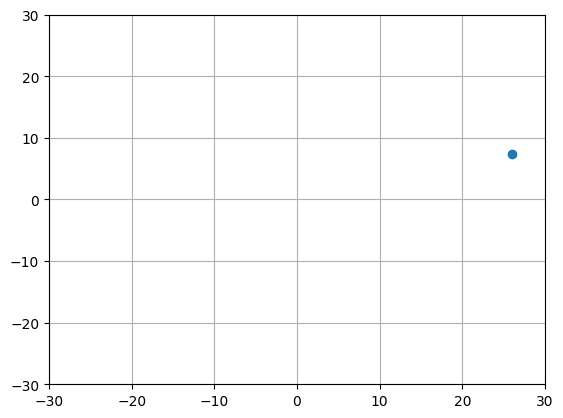

In [185]:
plt.scatter([qutip_hs_dist.real], [qutip_hs_dist.imag])
plt.grid()
plt.xlim([-30, 30])
plt.ylim([-30, 30])

Lets choose 3 points we can optimize around. Here they are at pi/4, 3pi/4 and 3pi/2

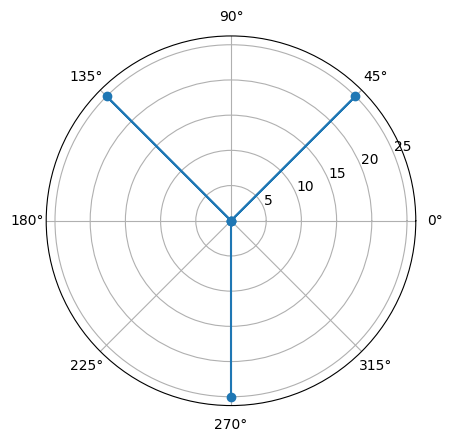

In [137]:
opt_point1 = 25 * np.exp(1j * np.pi/4)
opt_point2 = 25 * np.exp(1j * 3*np.pi/4)
opt_point3 = 25 * np.exp(1j * 3*np.pi/2)

plt.polar([0, np.angle(opt_point1), 0, np.angle(opt_point2),0,np.angle(opt_point3)], [0, np.abs(opt_point1), 0, np.abs(opt_point2),0,np.abs(opt_point3)], marker='o')

If we can possibly optimize a set of matrices centered around *different* points. Then we can use approximate computation (similar to QUEST) by calculating an average matrix of all of them. 

Lets define a new optimization function that takes in a shifted value from the HS distance. Then we perform swam optimization once more on each of these shifted distances

In [127]:
def swarm(center_point, num_particles=100, num_iters=1000):
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
    optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
    cost, pos = optimizer.optimize(opt_func_shift, iters=num_iters, center=center_point)
    return cost, pos

In [146]:
def opt_func_shift(vals, center):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        distances.append(get_hilbert_shmidt_distance(ccx_gate, approx_CCNOT_matrix))

    return  distances + center

In [152]:
cost_pos1, pos_pos1 = swarm(opt_point1, num_particles=100, num_iters=1000)
cost_pos2, pos_pos2 = swarm(opt_point2, num_particles=100, num_iters=1000)
cost_pos3, pos_pos3 = swarm(opt_point3, num_particles=100, num_iters=1000)

2023-02-24 18:51:38,870 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=14.9+17.5j
2023-02-24 19:04:25,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: (14.947570760863105+17.49957230658889j), best pos: [4.94852239 5.31990243 2.72016298 2.52436342 5.07355072 3.8872982
 2.90433733 1.47252178 4.87271872 1.472074   3.29548535 1.20690037
 3.28364791 4.07272721 3.05815181 5.13989982 3.56239027 2.45110943
 2.81320373 3.47888178 2.00305014 2.99351045 2.38845607 3.27279178
 3.76155527 1.73367278 3.60487945 1.57368081 3.47171195 4.63285325
 3.64088159 1.90793813 4.07857064 3.84096104 5.31429011 2.7523648
 5.35741858 2.64941561 3.77728354 3.41822824 0.33558311 2.59505671
 3.40351711 2.26134192 2.91022288]
2023-02-24 19:04:25,051 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global

In [153]:
tot_cost_pos1 = cost_pos1-opt_point1
tot_cost_pos2 = cost_pos2-opt_point2
tot_cost_pos3 = cost_pos3-opt_point3
print(tot_cost_pos1)

(-2.730098768800584-0.17809722307479348j)


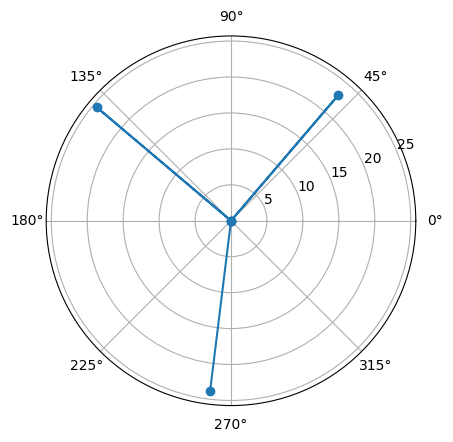

In [157]:
#plt.polar([0, np.angle(cost_pos1)], [0, np.abs(cost_pos1)], marker='o')
plt.polar([0, np.angle(cost_pos1), 0, np.angle(cost_pos2),0,np.angle(cost_pos3)], [0, np.abs(cost_pos1), 0, np.abs(cost_pos2),0,np.abs(cost_pos3)], marker='o')

In [168]:
array_to_latex(pos_to_matrix(pos_pos1))

<IPython.core.display.Latex object>

In [169]:
array_to_latex(pos_to_matrix(pos_pos2))

<IPython.core.display.Latex object>

In [170]:
array_to_latex(pos_to_matrix(pos_pos3))

<IPython.core.display.Latex object>

In [175]:
average_mat = (pos_to_matrix(pos_pos1) + pos_to_matrix(pos_pos2) + pos_to_matrix(pos_pos3)) / 3
array_to_latex(average_mat)

<IPython.core.display.Latex object>

In [172]:
get_hilbert_shmidt_distance(ccx_gate, average_mat)

(0.9684075801453074-0.3784580050822781j)

In [173]:
my_hilbert_schmidt_distance(ccx_gate, average_mat)

0.8768918012485036